In [ ]:
import gdown
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fig_width, fig_height = plt.rcParams['figure.figsize']

In [ ]:
def dereference(data):
    return np.vectorize(lambda ref: read_matlab_file(file[ref]), otypes=[object])(data)

def read_matlab_file(file):
    if isinstance(file, h5py.Dataset):
        data = file[()].squeeze()
        if data.dtype == h5py.ref_dtype:
            data = dereference(data)
    elif isinstance(file, h5py.Group):
        data = {}
        for subvar in file.keys():
            data[subvar] = read_matlab_file(file[subvar])
    return data

## (2) Spike Sorting from Scratch

### Getting Started

In [ ]:
# Download the data
url = "https://drive.google.com/file/d/1TWiaLBifUdOEtxXfl0GhATQFy8kP27Ek/view?usp=sharing"
gdown.download(url, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1TWiaLBifUdOEtxXfl0GhATQFy8kP27Ek
From (redirected): https://drive.google.com/uc?id=1TWiaLBifUdOEtxXfl0GhATQFy8kP27Ek&confirm=t&uuid=1b7f1e39-a31b-45a3-80ac-08ec694ae422
To: /content/Sorting_data.rar
100%|██████████| 269M/269M [00:04<00:00, 60.7MB/s]


'Sorting_data.rar'

In [ ]:
!unrar x Sorting_data.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from Sorting_data.rar

Creating    Sorting_data                                              OK
Extracting  Sorting_data/ross-data.mat                                     1%  3%  4%  6%  7%  9% 10% 12% 14% 15% 17% 18% 20% 21% 23% 24% 26% 28% 29% 31% 32% 34% 35% 37% 38% 40% 42% 43% 45% 46% 48% 49% 50%  OK 
Extracting  Sorting_data/singleIT.mat                                     51% 53% 54% 56% 57% 59% 60% 62% 64% 65% 67% 68% 70% 71% 73% 74% 76% 78% 79% 81% 82% 84% 85% 87% 88% 90% 92% 93% 95% 96% 98% 99%  OK 
All OK


In [ ]:
with h5py.File('Sorting_data/singleIT.mat', 'r') as file:
    data = file['data_IT'][()].squeeze()

In [ ]:
fs = 30000  # Sampling rate in Hz
t = np.arange(len(data)) / fs

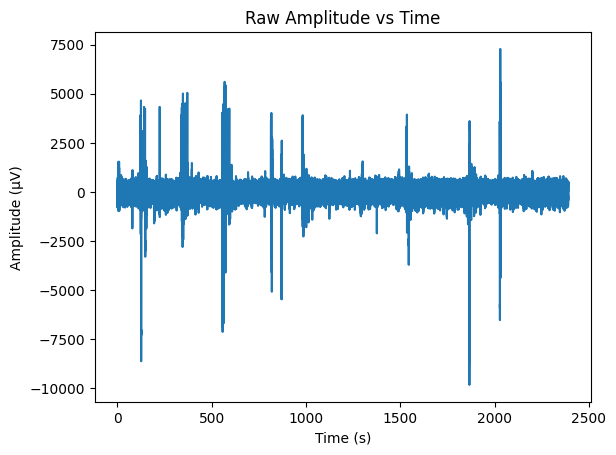

In [ ]:
# Plot raw signal
plt.plot(t, data)
plt.title('Raw Amplitude vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.savefig('raw_signal.pdf', bbox_inches='tight')
plt.show()

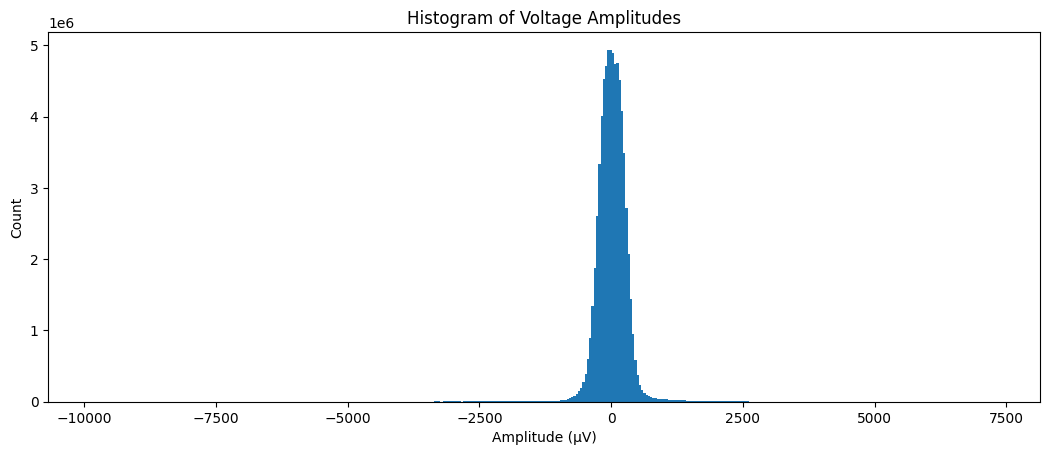

In [ ]:
# Histogram of voltages
plt.figure(figsize=(2 * fig_width, fig_height))

plt.hist(data, bins=400)
plt.title('Histogram of Voltage Amplitudes')
plt.xlabel('Amplitude (µV)')
plt.ylabel('Count')
plt.savefig('voltage_histogram.pdf', bbox_inches='tight')
plt.show()

### Filtering the Data

In [ ]:
from scipy.signal import butter, filtfilt

# Design Butterworth highpass filter (order=7, cutoff=300Hz)
def butter_highpass(cutoff, fs, order=7):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return butter(order, normal_cutoff, btype='high', analog=False)

b, a = butter_highpass(300, fs)
filtered = filtfilt(b, a, data)

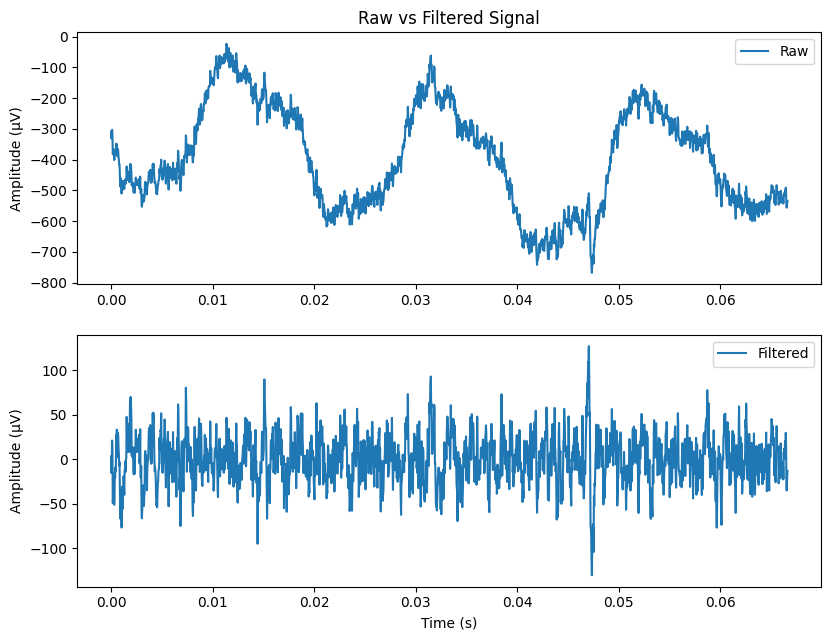

In [ ]:
# Plot before/after filtering
plt.figure(figsize=(1.5 * fig_width, 1.5 * fig_height))

plt.subplot(2, 1, 1)
plt.plot(t[:2000], data[:2000], label='Raw')
plt.title('Raw vs Filtered Signal')
plt.ylabel('Amplitude (µV)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:2000], filtered[:2000], label='Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()

plt.savefig('filtered_signal.pdf', bbox_inches='tight')
plt.show()

### Detecting the Spike

In [ ]:
# Spike detection
sigma_n = np.median(np.abs(filtered) / 0.6745)
theta = 5 * sigma_n

In [ ]:
from scipy.signal import find_peaks

positive_peaks, _ = find_peaks(filtered, height=theta)
negative_peaks, _ = find_peaks(-filtered, height=theta)

spike_inds = np.concatenate((positive_peaks, negative_peaks))

In [ ]:
# Extract waveforms: ±2ms = ±60 samples
window = int(0.002 * fs)
waveforms = []
valid_spike_inds = []

for idx in spike_inds:
    if idx - window >= 0 and idx + window < len(filtered):
        waveforms.append(filtered[idx - window:idx + window])
        valid_spike_inds.append(idx)

waveforms = np.array(waveforms)
valid_spike_inds = np.array(valid_spike_inds)

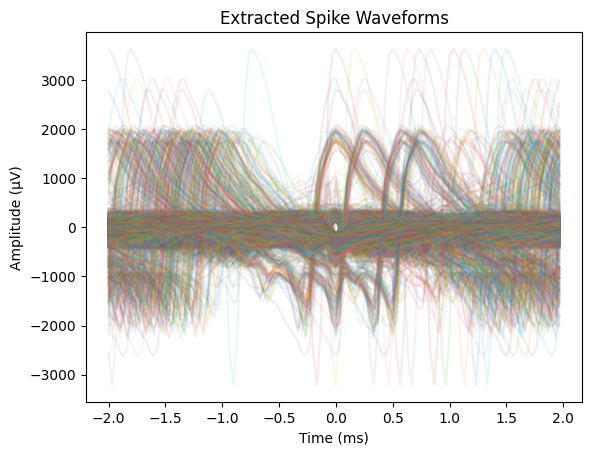

In [ ]:
# Plot all waveforms
t = np.arange(-window, window) / fs * 1000
for wf in waveforms:
    plt.plot(t, wf, alpha=0.1)
plt.title('Extracted Spike Waveforms')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.savefig('spike_waveforms.png', bbox_inches='tight')
plt.show()

### Extracting Features

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features = pca.fit_transform(waveforms)

### Clustering the Spikes

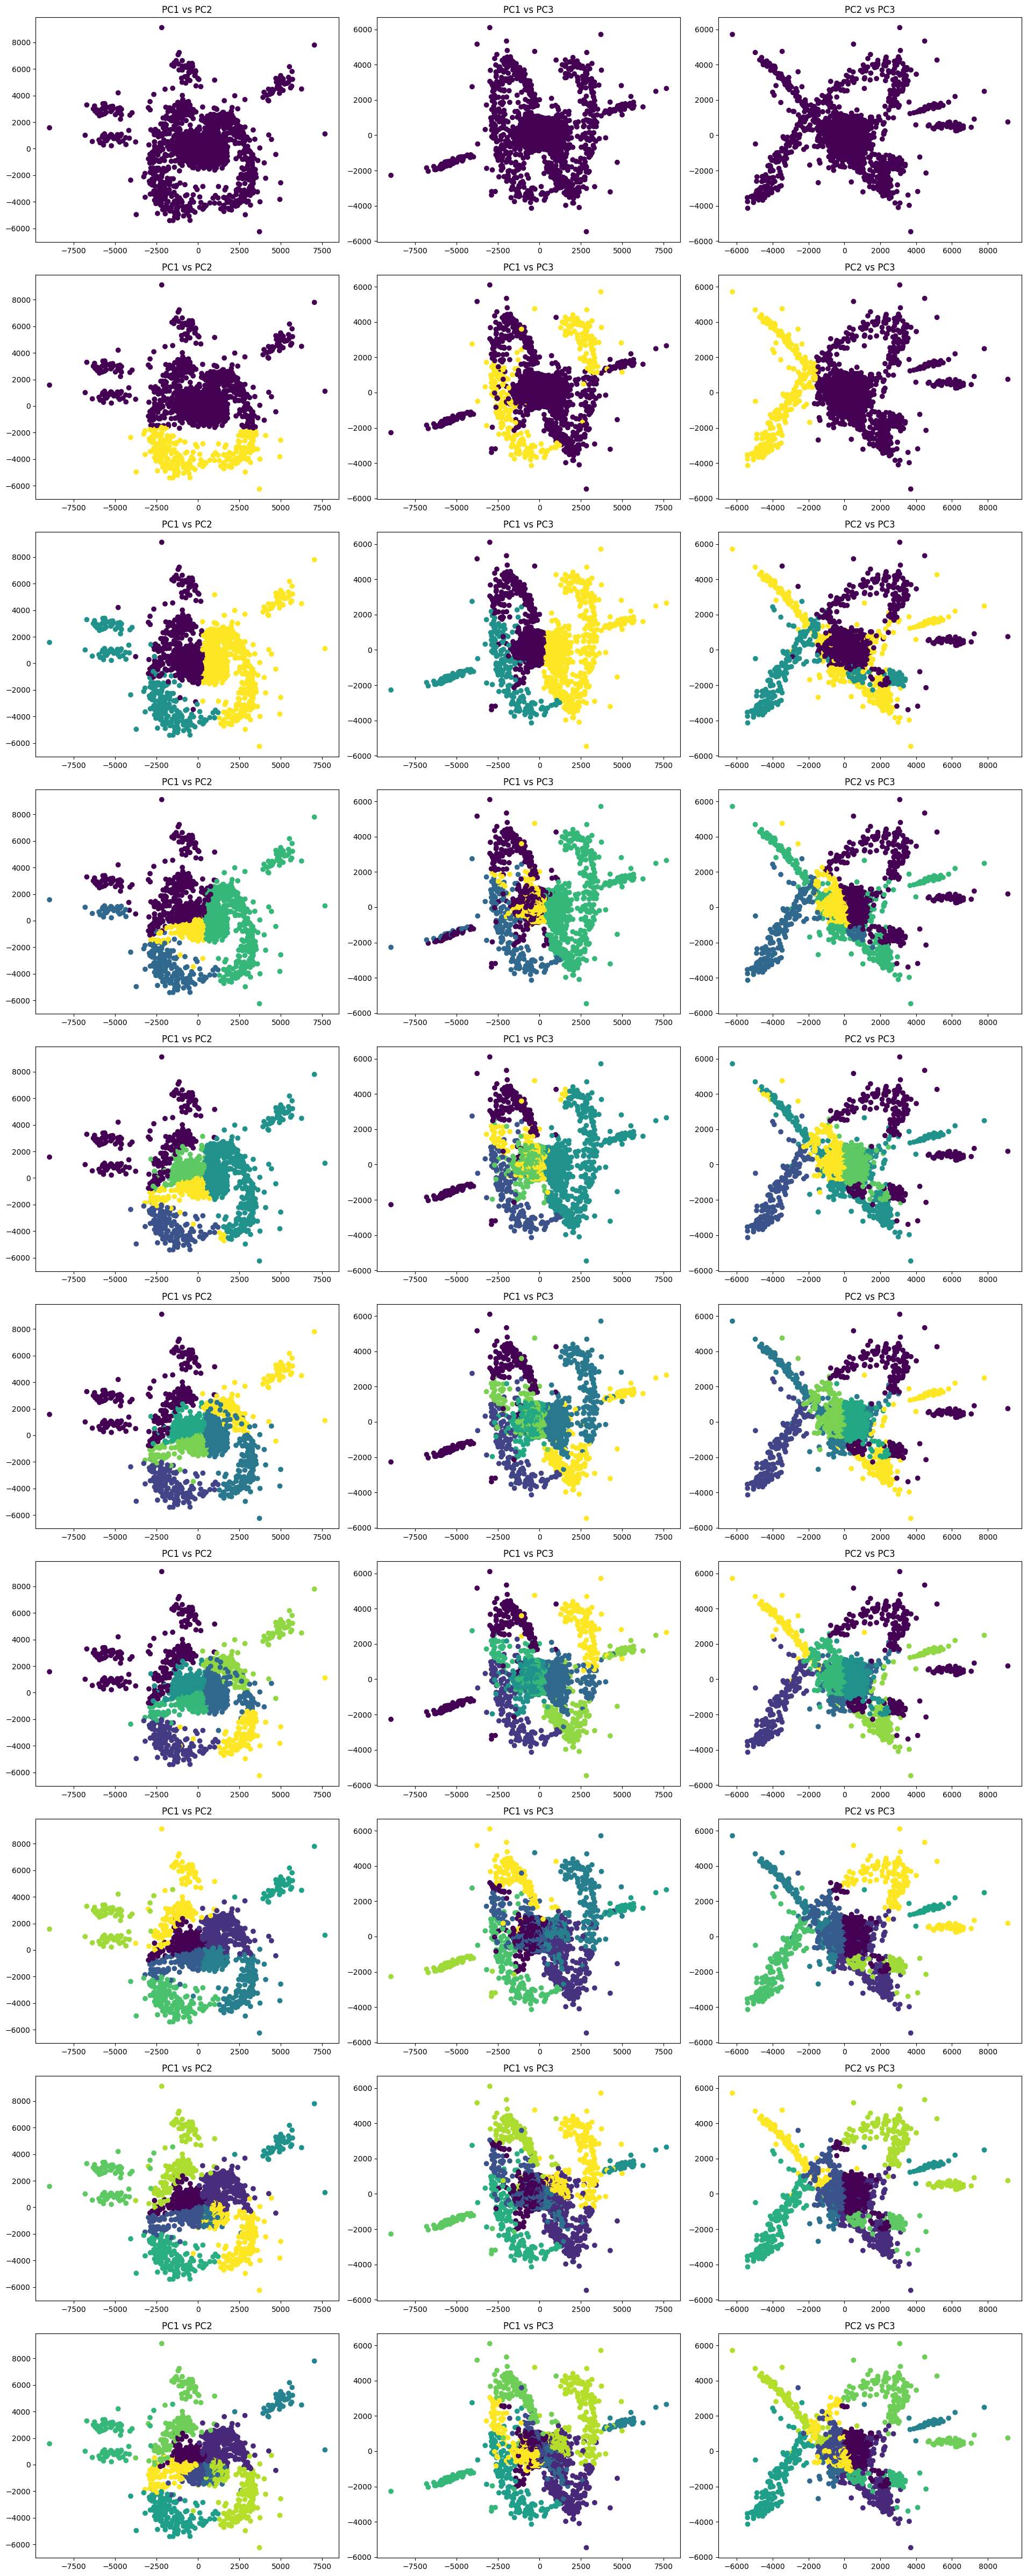

In [ ]:
from sklearn.cluster import KMeans

k_range = range(1, 11)
fig, axs = plt.subplots(len(k_range), 3, figsize=(3 * fig_width, len(k_range) * fig_height))

for i, k in enumerate(k_range):
    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    # Plot PCA scatter plots
    axs[i, 0].scatter(features[:, 0], features[:, 1], c=labels)
    axs[i, 0].set_title('PC1 vs PC2')
    axs[i, 1].scatter(features[:, 0], features[:, 2], c=labels)
    axs[i, 1].set_title('PC1 vs PC3')
    axs[i, 2].scatter(features[:, 1], features[:, 2], c=labels)
    axs[i, 2].set_title('PC2 vs PC3')

plt.tight_layout()
plt.savefig('pca_scatter_plots.pdf', bbox_inches='tight')
plt.show()

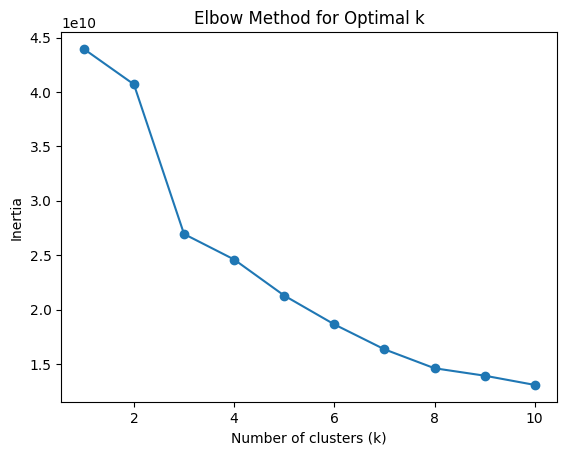

In [ ]:
# Compute inertia for different k values
inertias = list()
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_range, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig('elbow_method.pdf', bbox_inches='tight')
plt.show()

### Questions

#### Evaluation with `spikes.mat`

In [ ]:
url = "https://drive.google.com/file/d/1hkvhOVR8btHb-z0cSfSHBlwcb08fplVb/view?usp=sharing"
gdown.download(url, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1hkvhOVR8btHb-z0cSfSHBlwcb08fplVb
From (redirected): https://drive.google.com/uc?id=1hkvhOVR8btHb-z0cSfSHBlwcb08fplVb&confirm=t&uuid=127118a4-eafc-4c49-8ce0-c4c8eac0a375
To: /content/Spikes.mat
100%|██████████| 124k/124k [00:00<00:00, 68.1MB/s]


'Spikes.mat'

In [ ]:
with h5py.File('Spikes.mat', 'r') as file:
    ind_spikes_it = file['ind_spikes_it'][()].squeeze()

ind_spikes_it = ind_spikes_it.astype(int)

In [ ]:
np.intersect1d(spike_inds, ind_spikes_it)

array([ 32547,  51030,  56552,  63330, 108606, 119416, 134042, 134052])

#### Determining a New Threshold

In [ ]:
# New threshold based on max amplitude
theta_new = 0.9 * np.max(filtered)

In [ ]:
positive_peaks, _ = find_peaks(filtered, height=theta_new)
negative_peaks, _ = find_peaks(-filtered, height=theta_new)

np.concatenate((positive_peaks, negative_peaks))

array([60853198])

#### Using t-SNE Instead of PCA

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
features = tsne.fit_transform(waveforms)

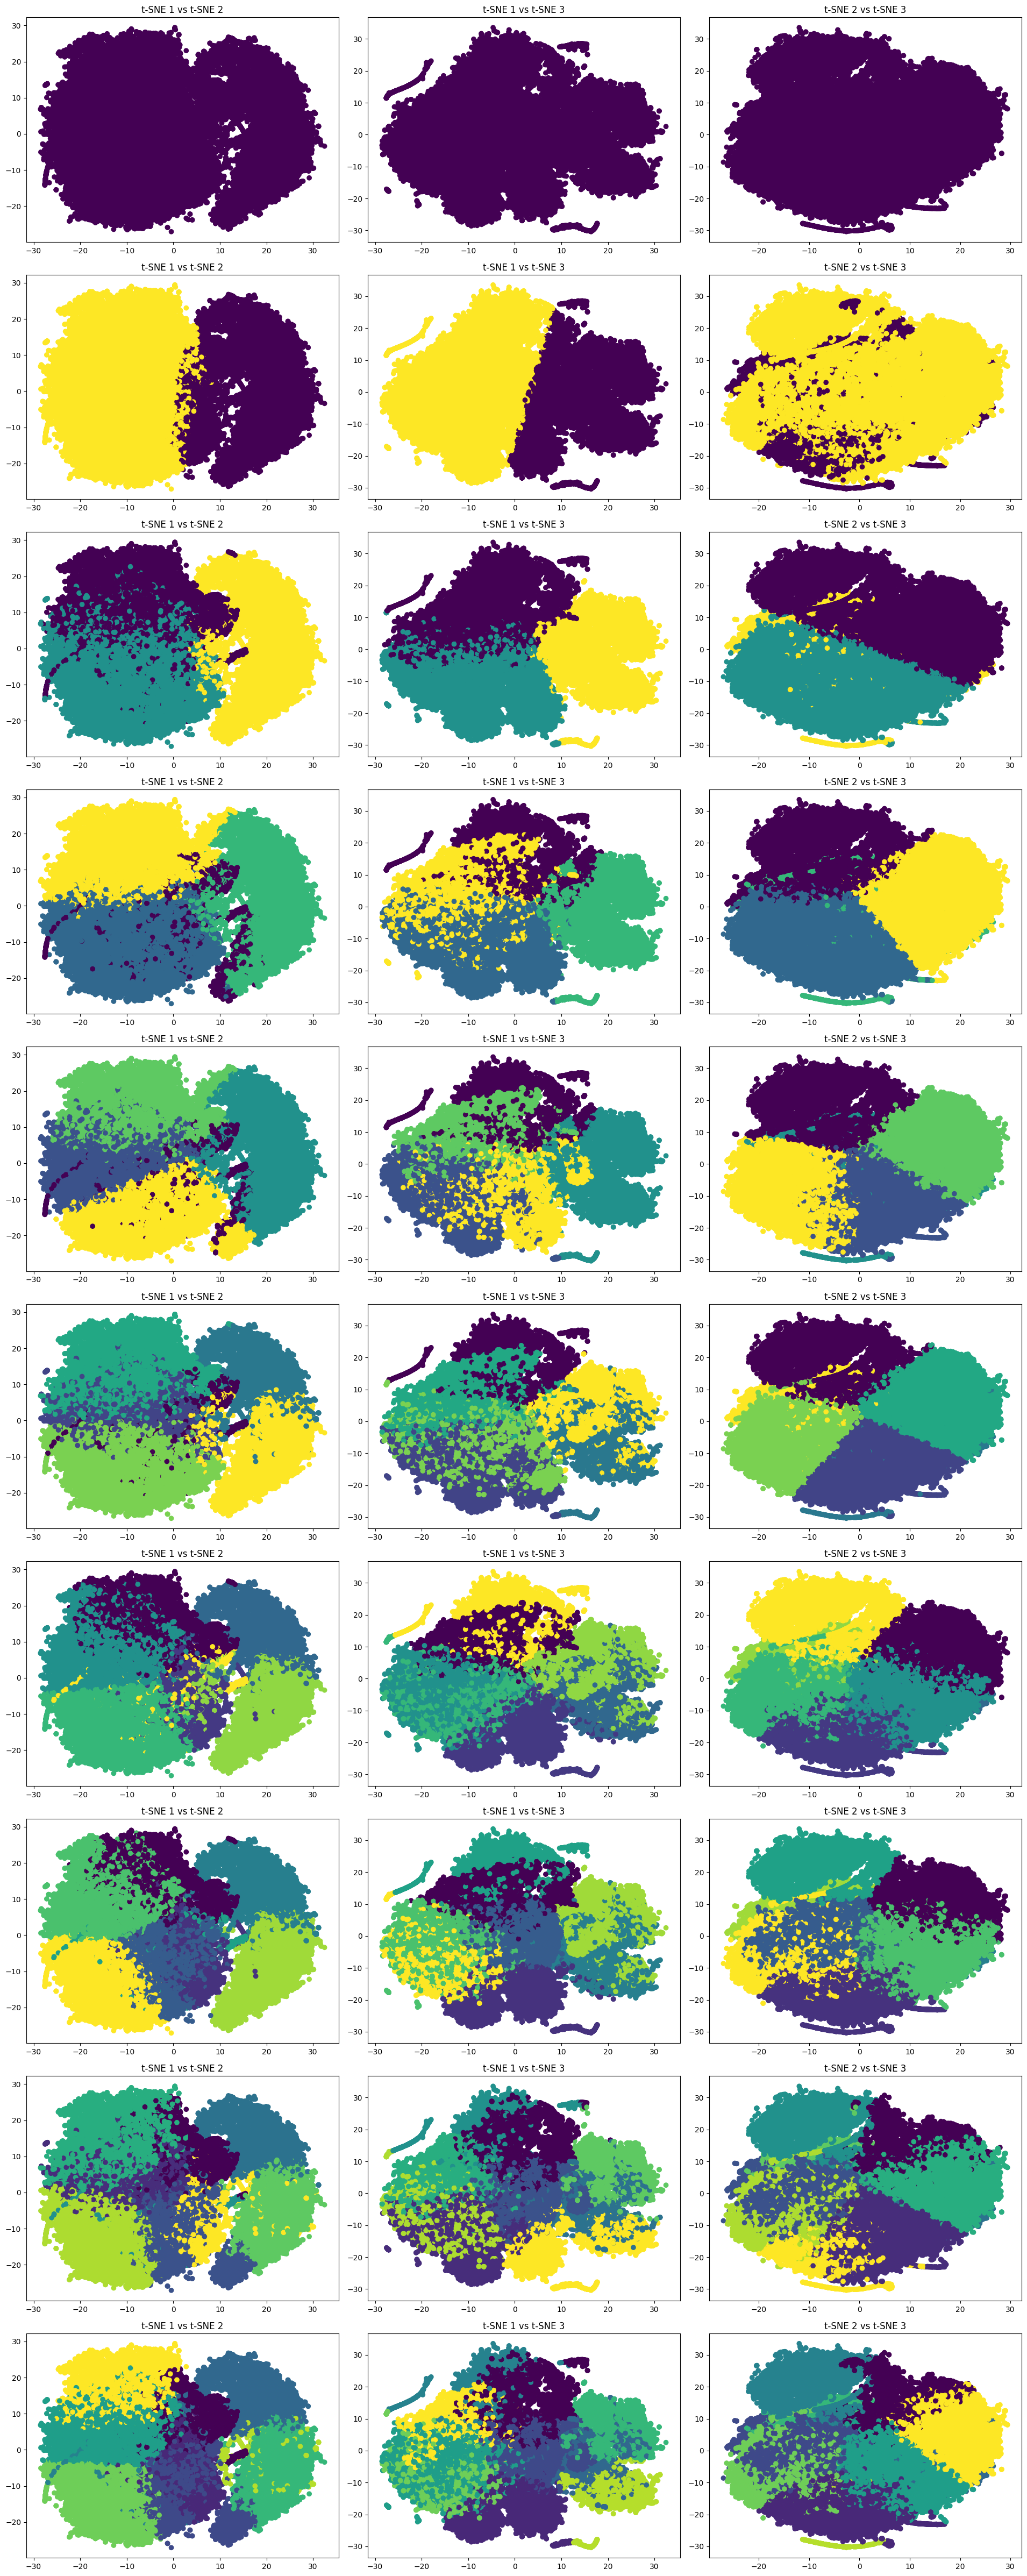

In [ ]:
from sklearn.cluster import KMeans

k_range = range(1, 11)
fig, axs = plt.subplots(len(k_range), 3, figsize=(3 * fig_width, len(k_range) * fig_height))

for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    axs[i, 0].scatter(features[:, 0], features[:, 1], c=labels)
    axs[i, 0].set_title('t-SNE 1 vs t-SNE 2')
    axs[i, 1].scatter(features[:, 0], features[:, 2], c=labels)
    axs[i, 1].set_title('t-SNE 1 vs t-SNE 3')
    axs[i, 2].scatter(features[:, 1], features[:, 2], c=labels)
    axs[i, 2].set_title('t-SNE 2 vs t-SNE 3')

plt.tight_layout()
plt.savefig('tsne_scatter_plots.pdf', bbox_inches='tight')
plt.show()

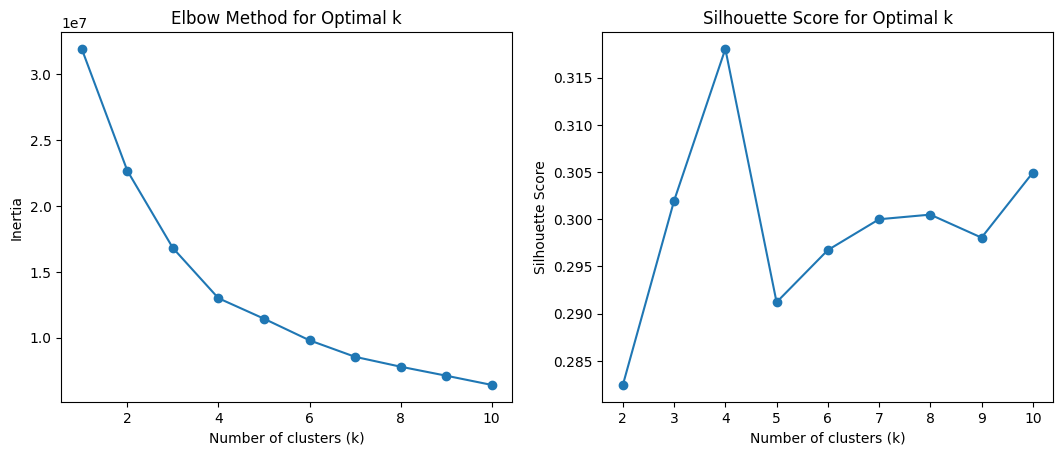

In [ ]:
from sklearn.metrics import silhouette_score

inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

    if k > 1:
        silhouette_scores.append(silhouette_score(features, kmeans.labels_))
    else:
        silhouette_scores.append(None)

# Plot inertia (elbow method)
plt.figure(figsize=(2 * fig_width, fig_height))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.savefig('tsne_elbow_method_silhouette.pdf', bbox_inches='tight')
plt.show()

## (4) Analysis of Single Neuron Activity

In [ ]:
url = "https://drive.google.com/file/d/1QypL9YFmrKpbgh7JYA6uZYTI7Nw7wXMP/view?usp=sharing"
gdown.download(url, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1QypL9YFmrKpbgh7JYA6uZYTI7Nw7wXMP
From (redirected): https://drive.google.com/uc?id=1QypL9YFmrKpbgh7JYA6uZYTI7Nw7wXMP&confirm=t&uuid=875949d6-aa7d-4cc0-b9a8-85e329fde76e
To: /content/dataVasati.mat
100%|██████████| 949M/949M [00:13<00:00, 72.4MB/s]


'dataVasati.mat'

In [ ]:
with h5py.File('dataVasati.mat', 'r') as file:
    dataVasati = read_matlab_file(file['SpikeTrain_it_all'])

data = dataVasati['data']
cm = dataVasati['cm']
cm_index = dataVasati['cm_index']

data = np.vectorize(lambda arr: arr.T, otypes=[object])(data)

In [ ]:
sampling_rate = 1000
n_neurons = data.size
n_trials = data[0].shape[0]
time_points = data[0].shape[1]
n_stimuli = 500
n_stimulus_trials = 10

categories = {
    "face": (1, 200),
    "body": (201, 320),
    "natural": (321, 390),
    "artificial": (391, 500)
}

### PSTH Analysis

In [ ]:
for n, (neuron_data, neuron_cm) in enumerate(zip(data, cm)):
    grouped_trails = [[] for _ in range(n_stimuli)]
    for trail, stimulus in zip(neuron_data, neuron_cm['index']):
        grouped_trails[stimulus.astype(int) - 1].append(trail)

    data[n] = np.mean(np.array(grouped_trails), axis=1) * sampling_rate

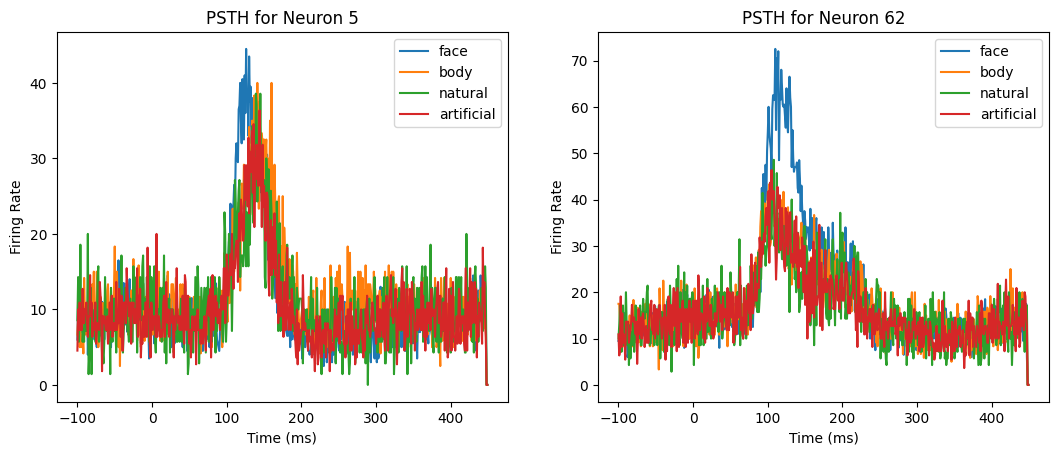

In [ ]:
plt.figure(figsize=(2 * fig_width, fig_height))

for i, selected_neuron in enumerate([5, 62]):
    plt.subplot(1, 2, i + 1)
    neuron_data = data[selected_neuron - 1]
    for category, (start, end) in categories.items():
        cat_trials = neuron_data[start-1 : end]
        psth = np.mean(cat_trials, axis=0)
        plt.plot(np.arange(-100, 450), psth, label=category)

    plt.title(f'PSTH for Neuron {selected_neuron}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate')
    plt.legend()

plt.savefig('psth_analysis.pdf', bbox_inches='tight')
plt.show()

### Fano Factor Analysis

In [ ]:
window_size = 50
step_size = 5
n_windows = (time_points - window_size) // step_size + 1

In [ ]:
for n, neuron_data in enumerate(data):
    spike_counts = np.zeros((neuron_data.shape[0], n_windows))
    for i in range(n_windows):
        start = i * step_size
        end = start + window_size
        spike_counts[:, i] = np.sum(neuron_data[:, start:end], axis=1)

    data[n] = spike_counts

In [ ]:
import pandas as pd

bins = [0, 200, 320, 390, 500]

trial_categories = list()
for neuron in range(n_neurons):
    trial_categories.append(pd.cut(cm[neuron]['index'], bins=bins, labels=categories.keys()).to_numpy())

trial_categories = np.array(trial_categories)

#### Fano Factor

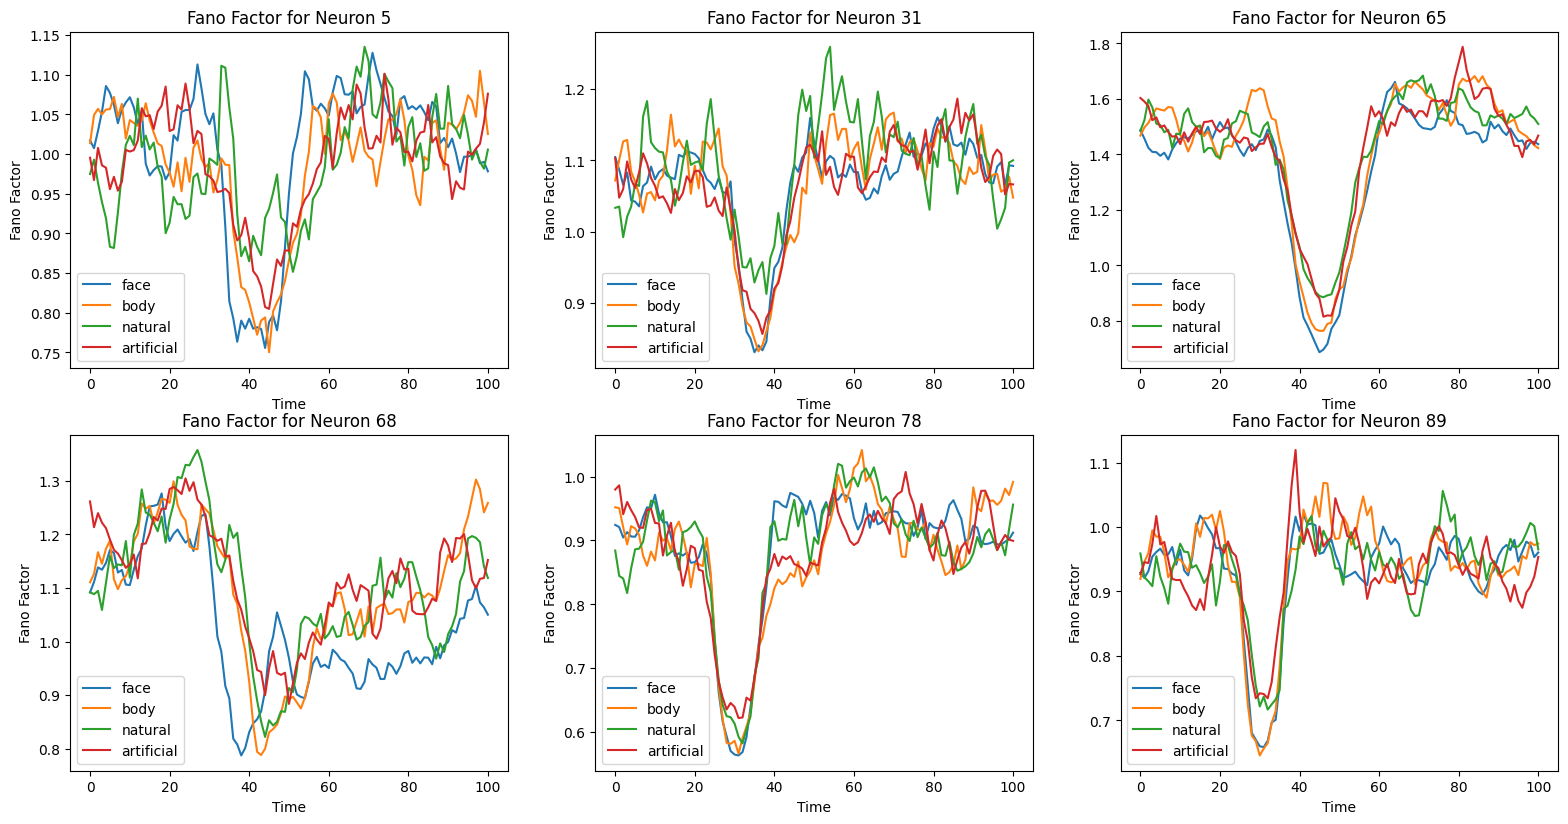

In [ ]:
plt.figure(figsize=(3 * fig_width, 2 * fig_height))

for i, selected_neuron in enumerate([5, 31, 65, 68, 78, 89]):
    plt.subplot(2, 3, i + 1)
    neuron_data = data[selected_neuron - 1]
    for category, (start, end) in categories.items():
        cat_trials = neuron_data[trial_categories[selected_neuron - 1] == category]
        cat_fanos = list()
        for w in range(n_windows):
            window_data = cat_trials[:, w]
            mean = np.mean(window_data)
            var = np.var(window_data)
            fano = var / mean if mean > 0 else np.nan
            cat_fanos.append(fano)

        plt.plot(cat_fanos, label=category)

    plt.title(f'Fano Factor for Neuron {selected_neuron}')
    plt.xlabel('Time')
    plt.ylabel('Fano Factor')
    plt.legend()

plt.savefig('fano_factor.pdf', bbox_inches='tight')
plt.show()

#### Mean-Matched Fano Factor

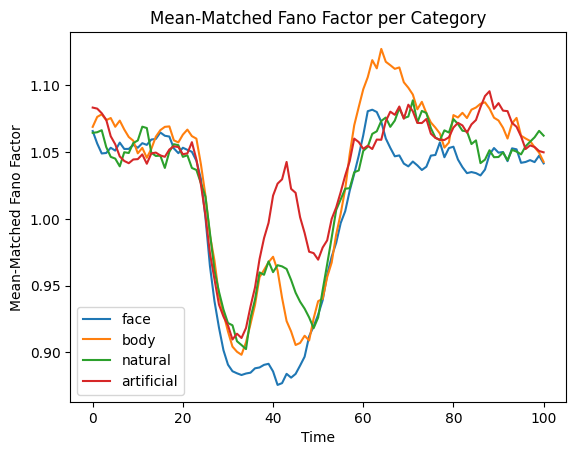

In [ ]:
from sklearn.linear_model import LinearRegression

for category, (start, end) in categories.items():
    slopes = list()
    for w in range(n_windows):
        means, vars = list(), list()
        for neuron in range(n_neurons):
            neuron_spike_counts = data[neuron][trial_categories[neuron] == category, w]
            means.append(np.mean(neuron_spike_counts))
            vars.append(np.var(neuron_spike_counts))

        reg = LinearRegression(fit_intercept=False).fit(np.array(means).reshape(-1, 1), vars)
        slopes.append(reg.coef_[0])

    plt.plot(slopes, label=category)

plt.title('Mean-Matched Fano Factor per Category')
plt.xlabel('Time')
plt.ylabel('Mean-Matched Fano Factor')
plt.legend()
plt.savefig('mean_matched_fano_factor.pdf', bbox_inches='tight')
plt.show()

### Category Classification Using SVM

In [ ]:
data = np.stack(data)

data.shape

(92, 500, 101)

In [ ]:
# Assign numerical labels (0, 1, 2, 3)
labels = np.zeros(n_stimuli, dtype=int)
for label, (start, end) in enumerate(categories.values()):
    labels[start-1:end] = label

In [ ]:
url = "https://drive.google.com/file/d/1oni-M5k5Kx6W-mvc5Vd0sPagaLZQ9tM9/view?usp=sharing"
gdown.download(url, quiet = True, fuzzy=True)
!unrar x -idq HW2_files.rar

import sys
from pathlib import Path

# Add the HW2_files directory to Python path
sys.path.append(str(Path("/content/HW2_files/SRC/Python/")))

from gen_fx_get_svm import gen_fx_get_svm

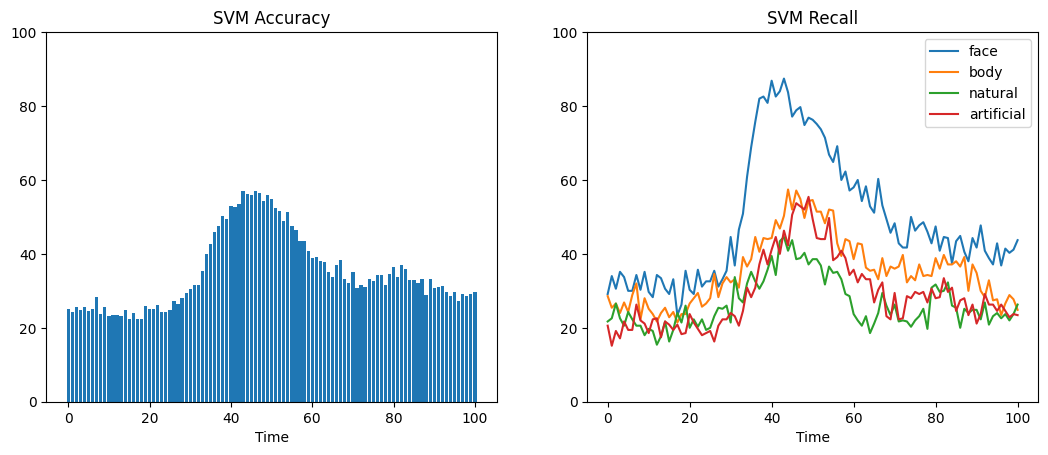

In [ ]:
accuracy, recall = list(), list()
for w in range(n_windows):
    result, _ = gen_fx_get_svm(labels, data[:, :, w].T, 0.5, 10)
    accuracy.append(np.mean(result['pt']) * 100)
    recall.append(np.mean(result['tu'], axis=0) * 100)


plt.figure(figsize=(2 * fig_width, fig_height))

plt.subplot(1, 2, 1)
plt.bar(range(len(accuracy)), accuracy)
plt.ylim(0, 100)
plt.title("SVM Accuracy")
plt.xlabel("Time")
plt.ylabel("")

plt.subplot(1, 2, 2)
plt.plot(recall, label=categories.keys())
plt.ylim(0, 100)
plt.title("SVM Recall")
plt.xlabel("Time")
plt.ylabel("")
plt.legend()

plt.savefig('svm_classification.pdf', bbox_inches='tight')
plt.show()

### Time-Time Decoding Analysis

In [ ]:
def time_time_decoding(data, labels):
    decoding_matrix = list()
    for train_w in range(n_windows):
        _, model = gen_fx_get_svm(labels, data[:, :, train_w].T, 0.5, 10)
        decoding_matrix.append([model.score(data[:, :, test_w].T, labels) for test_w in range(n_windows)])

    return np.array(decoding_matrix)


decoding_matrix = time_time_decoding(data, labels)

#### Permutation Test

In [ ]:
perm_matrices = list()
for p in range(50):
    labels_perm = np.random.permutation(labels)
    perm_matrices.append(time_time_decoding(data, labels_perm))

perm_matrices = np.array(perm_matrices)

In [ ]:
p_matrix = np.mean(perm_matrices >= decoding_matrix[None, :, :], axis=0)
p_flat = p_matrix.flatten()

#### FDR Correction

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

rejected, _ = fdrcorrection(p_flat, alpha=0.05)
rejected = rejected.reshape(decoding_matrix.shape)

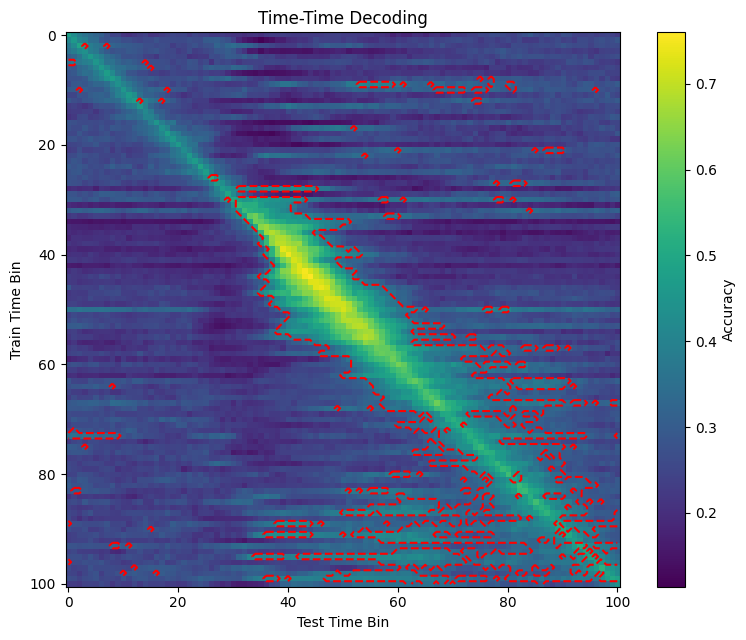

In [ ]:
plt.figure(figsize=(1.5 * fig_width, 1.5 * fig_height))

plt.imshow(decoding_matrix)
plt.colorbar(label='Accuracy')
plt.contour(rejected, colors='red', linestyles='dashed')
plt.xlabel("Test Time Bin")
plt.ylabel("Train Time Bin")
plt.title("Time-Time Decoding")
plt.savefig('time_time_decoding_fdrcorrection.pdf', bbox_inches='tight')
plt.show()

### Mutual Information Analysis Across Time

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def mutual_info(data, labels):
    mi_scores = []
    for w in range(n_windows):
        mi = mutual_info_classif(data[:, :, w].T, labels, discrete_features=True)
        mi_scores.append(mi.mean())

    return np.array(mi_scores)

mi_scores = mutual_info(data, labels)

In [ ]:
null_distributions = list()
for i in range(100):
    shuffled_labels = np.random.permutation(labels)
    null_distributions.append(mutual_info(data, shuffled_labels))

# Calculate 95th percentile threshold
thresholds = np.percentile(np.array(null_distributions), 95, axis=0)
significant = mi_scores > thresholds

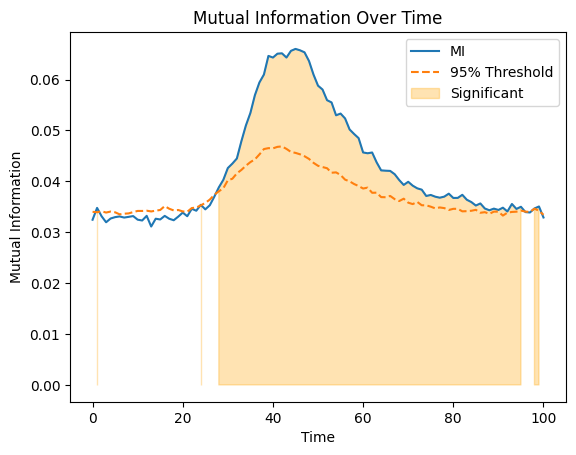

In [ ]:
time_axis = np.arange(n_windows)
plt.plot(time_axis, mi_scores, label='MI')
plt.plot(time_axis, thresholds, '--', label='95% Threshold')
plt.fill_between(time_axis, 0, mi_scores, where=significant, color='orange', alpha=0.3, label='Significant')
plt.xlabel('Time')
plt.ylabel('Mutual Information')
plt.title('Mutual Information Over Time')
plt.legend()
plt.savefig('mutual_information_over_time.pdf', bbox_inches='tight')
plt.show()

### Category Discriminability Using d-prime

In [ ]:
def compute_dprime(x1, x2):
    mu1, mu2 = np.mean(x1), np.mean(x2)
    s1, s2 = np.var(x1), np.var(x2)
    return (mu1 - mu2) / np.sqrt(0.5 * (s1 + s2))

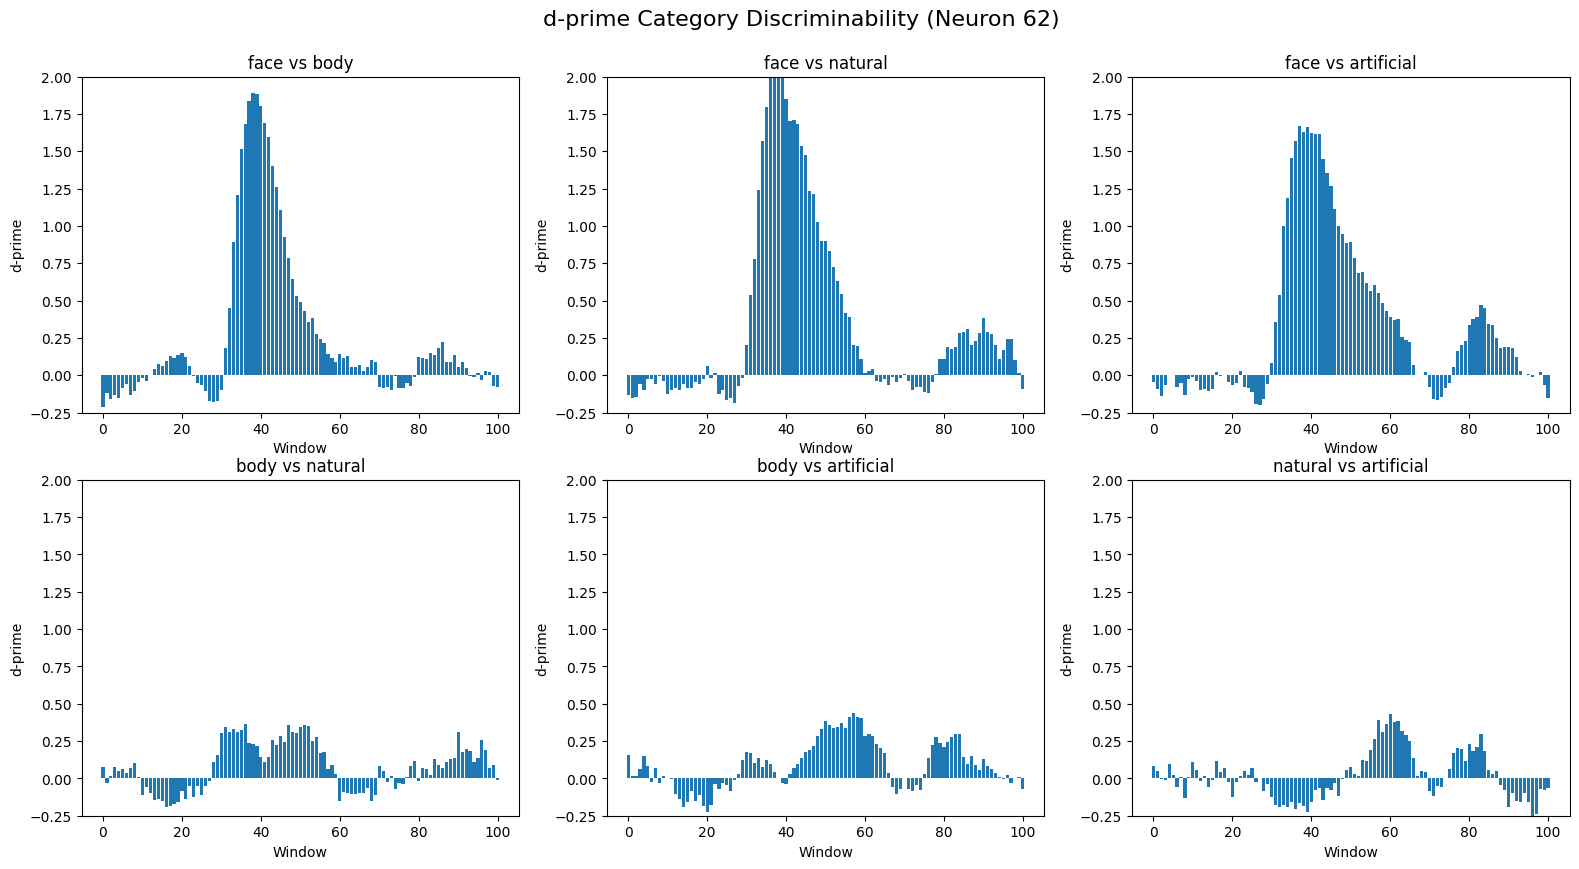

In [ ]:
import itertools

neuron_id = 62
neuron_data = data[neuron_id - 1]

plt.figure(figsize=(3 * fig_width, 2 * fig_height))

for i, ((category1, (start1, end1)), (category2, (start2, end2))) in enumerate(itertools.combinations(categories.items(), 2)):
    cat1_trials = neuron_data[start1-1 : end1]
    cat2_trials = neuron_data[start2-1 : end2]
    dprimes = [compute_dprime(cat1_trials[:, w], cat2_trials[:, w]) for w in range(n_windows)]

    plt.subplot(2, 3, i + 1)
    plt.bar(range(len(dprimes)), dprimes)
    plt.ylim(-0.25, 2)
    plt.xlabel('Window')
    plt.ylabel('d-prime')
    plt.title(f'{category1} vs {category2}')

plt.suptitle(f"d-prime Category Discriminability (Neuron {neuron_id})", fontsize=16, y=0.95)
plt.savefig('category_discriminability.pdf', bbox_inches='tight')
plt.show()

## (5) Analysis of Population Activity

### Representational Dissimilarity Matrix (RDM) and Kendall’s Tau Correlation

In [ ]:
from scipy.spatial.distance import pdist, squareform

rdms = list()

for w in range(n_windows):
    reps = data[:, :, w].T
    dists = squareform(pdist(reps, metric='correlation'))
    rdms.append(dists)

rdms = np.array(rdms)

In [ ]:
gt_rdm = np.ones((n_stimuli, n_stimuli))
for start, end in categories.values():
    gt_rdm[start-1:end, start-1:end] = 0

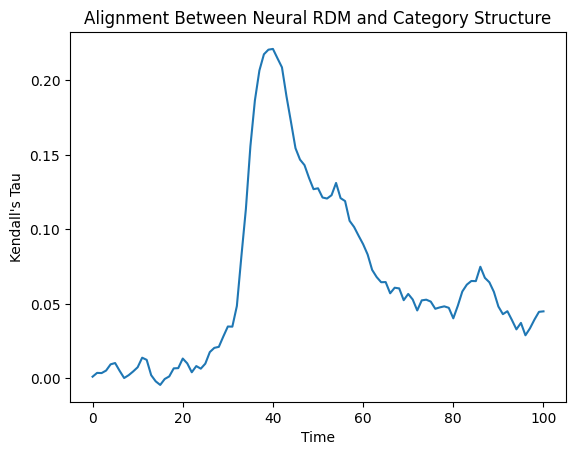

In [ ]:
from scipy.stats import kendalltau

tau_scores = []
for w in range(n_windows):
    tau, _ = kendalltau(gt_rdm.flatten(), rdms[w].flatten())
    tau_scores.append(tau)

plt.plot(tau_scores)
plt.xlabel('Time')
plt.ylabel("Kendall's Tau")
plt.title("Alignment Between Neural RDM and Category Structure")
plt.savefig('alignment_between_rdm_and_category_structure.pdf', bbox_inches='tight')
plt.show()

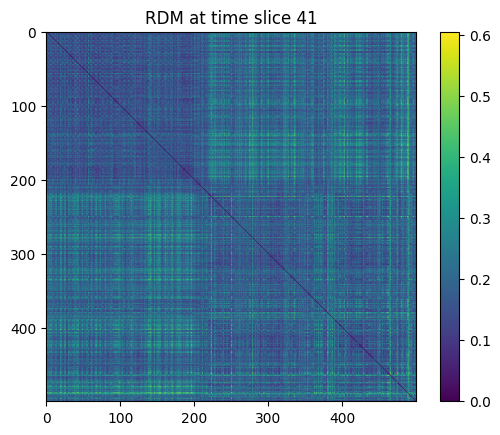

In [ ]:
best_w = np.argmax(tau_scores)

plt.imshow(rdms[best_w])
plt.title(f'RDM at time slice {best_w + 1}')
plt.colorbar()
plt.savefig('rdm_at_best_time_slice.pdf', bbox_inches='tight')
plt.show()

### Generalized Linear Model (GLM) to Predict Ground Truth RDM

In [ ]:
url = "https://drive.google.com/file/d/14F2_kORhpueTky9GVepqlHQt2jGmQCDK/view?usp=sharing"
gdown.download(url, fuzzy=True)
!unrar x -idq Stimuli.rar

Downloading...
From (original): https://drive.google.com/uc?id=14F2_kORhpueTky9GVepqlHQt2jGmQCDK
From (redirected): https://drive.google.com/uc?id=14F2_kORhpueTky9GVepqlHQt2jGmQCDK&confirm=t&uuid=b530fb6a-764f-4546-a7a0-3f966e7c2a8e
To: /content/Stimuli.rar
100%|██████████| 41.2M/41.2M [00:01<00:00, 35.3MB/s]


In [ ]:
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import os
from PIL import Image

images = []
for i in range(1, 501):
    img_path = os.path.join("Stimuli", f"{i:03}.tif")
    img = Image.open(img_path)
    img_tensor = transform(img)
    images.append(img_tensor)

images = torch.stack(images)

In [ ]:
from torch import nn
from torchvision.models import vgg16, VGG16_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16(weights=VGG16_Weights.DEFAULT).to(device)
model.eval()

# We'll take features before classification layer (fc1)
model_features = nn.Sequential(*list(model.classifier.children())[:2])

features = []

with torch.no_grad():
    for img in images.to(device):
        x = model.features(img.unsqueeze(0))
        x = torch.flatten(x, 1)
        x = model_features(x)
        features.append(x.squeeze().cpu().numpy())

features = np.stack(features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 47.8MB/s]


In [ ]:
visual_rdm = squareform(pdist(features, metric='cosine'))
X_visual = squareform(visual_rdm, checks=False)

In [ ]:
y = squareform(gt_rdm, checks=False)
X_neural = np.array([squareform(rdm, checks=False) for rdm in rdms])

In [ ]:
import statsmodels.api as sm

r2_scores = []

for w in range(n_windows):
    X = np.vstack([X_neural[w], X_visual]).T
    X = sm.add_constant(X)  # add intercept term

    glm_model = sm.GLM(y, X, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    r2_like = 1 - glm_results.deviance / glm_results.null_deviance
    r2_scores.append(r2_like)

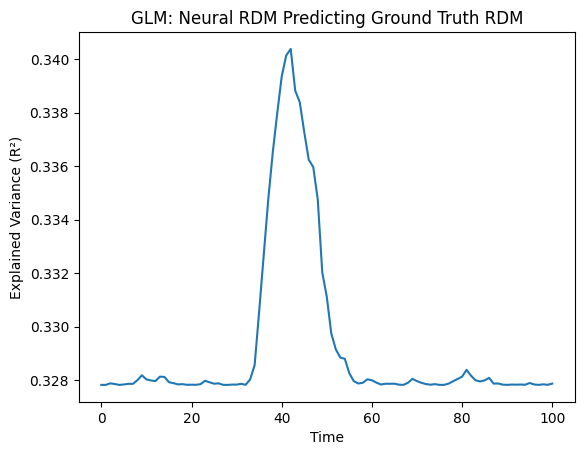

In [ ]:
plt.plot(r2_scores)
plt.xlabel("Time")
plt.ylabel("Explained Variance (R²)")
plt.title("GLM: Neural RDM Predicting Ground Truth RDM")
plt.savefig('glm_neural_rdm_predicting_ground_truth_rdm_2.pdf', bbox_inches='tight')
plt.show()

## (6) Phase-Amplitude Coupling (PAC) and Spectrum Analysis

In [ ]:
pip install tensorpac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
url = "https://drive.google.com/file/d/12y6-BQGpF0xU1Cec84Vn9-qo3g-DmX8X/view?usp=sharing"
gdown.download(url, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=12y6-BQGpF0xU1Cec84Vn9-qo3g-DmX8X
From (redirected): https://drive.google.com/uc?id=12y6-BQGpF0xU1Cec84Vn9-qo3g-DmX8X&confirm=t&uuid=ce64158d-c618-4130-9a1e-00ba46de08ba
To: /content/data_LFP.mat
100%|██████████| 947M/947M [00:14<00:00, 66.7MB/s]


'data_LFP.mat'

In [ ]:
with h5py.File('data_LFP.mat', 'r') as file:
    data_LFP = read_matlab_file(file['data_LFP_it'])

data_it = data_LFP['data_it']
cm = data_LFP['cm']

In [ ]:
face_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 27, 75, 76, 77, 78, 79, 80, 81, 82, 83, 102, 103, 104, 105, 106, 107, 108, 109, 110, 129, 130, 131, 132, 133, 134, 135, 136, 137, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
body_labels = [14, 16, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 84, 85, 86, 87, 88, 89, 111, 112, 113, 114, 115, 116, 138, 139, 140, 141, 142, 143]
natural_labels = [32, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 72, 73, 90, 91, 92, 93, 94, 95, 117, 118, 119, 120, 121, 122, 144, 145, 146, 147, 148, 149]
artifact_labels = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 96, 97, 98, 99, 100, 101, 123, 124, 125, 126, 127, 128, 150, 151, 152, 153, 154, 155]

In [ ]:
selected_neuron = 122

neuron_data = data_it[selected_neuron - 1]
neuron_cm = cm[selected_neuron - 1]

n_epochs = neuron_data.shape[1]

category_data = {
    "face": np.array([neuron_data[:, i] for i in range(n_epochs) if neuron_cm[i] in face_labels]),
    "body": np.array([neuron_data[:, i] for i in range(n_epochs) if neuron_cm[i] in body_labels]),
    "natural": np.array([neuron_data[:, i] for i in range(n_epochs) if neuron_cm[i] in natural_labels]),
    "artifact": np.array([neuron_data[:, i] for i in range(n_epochs) if neuron_cm[i] in artifact_labels])
}

In [ ]:
sf = 1000

bands = {
    "theta": np.linspace(4, 8, 5),
    "alpha": np.linspace(8, 12, 5),
    "beta": np.linspace(13, 30, 10),
    "gamma": np.linspace(30, 100, 20)
}

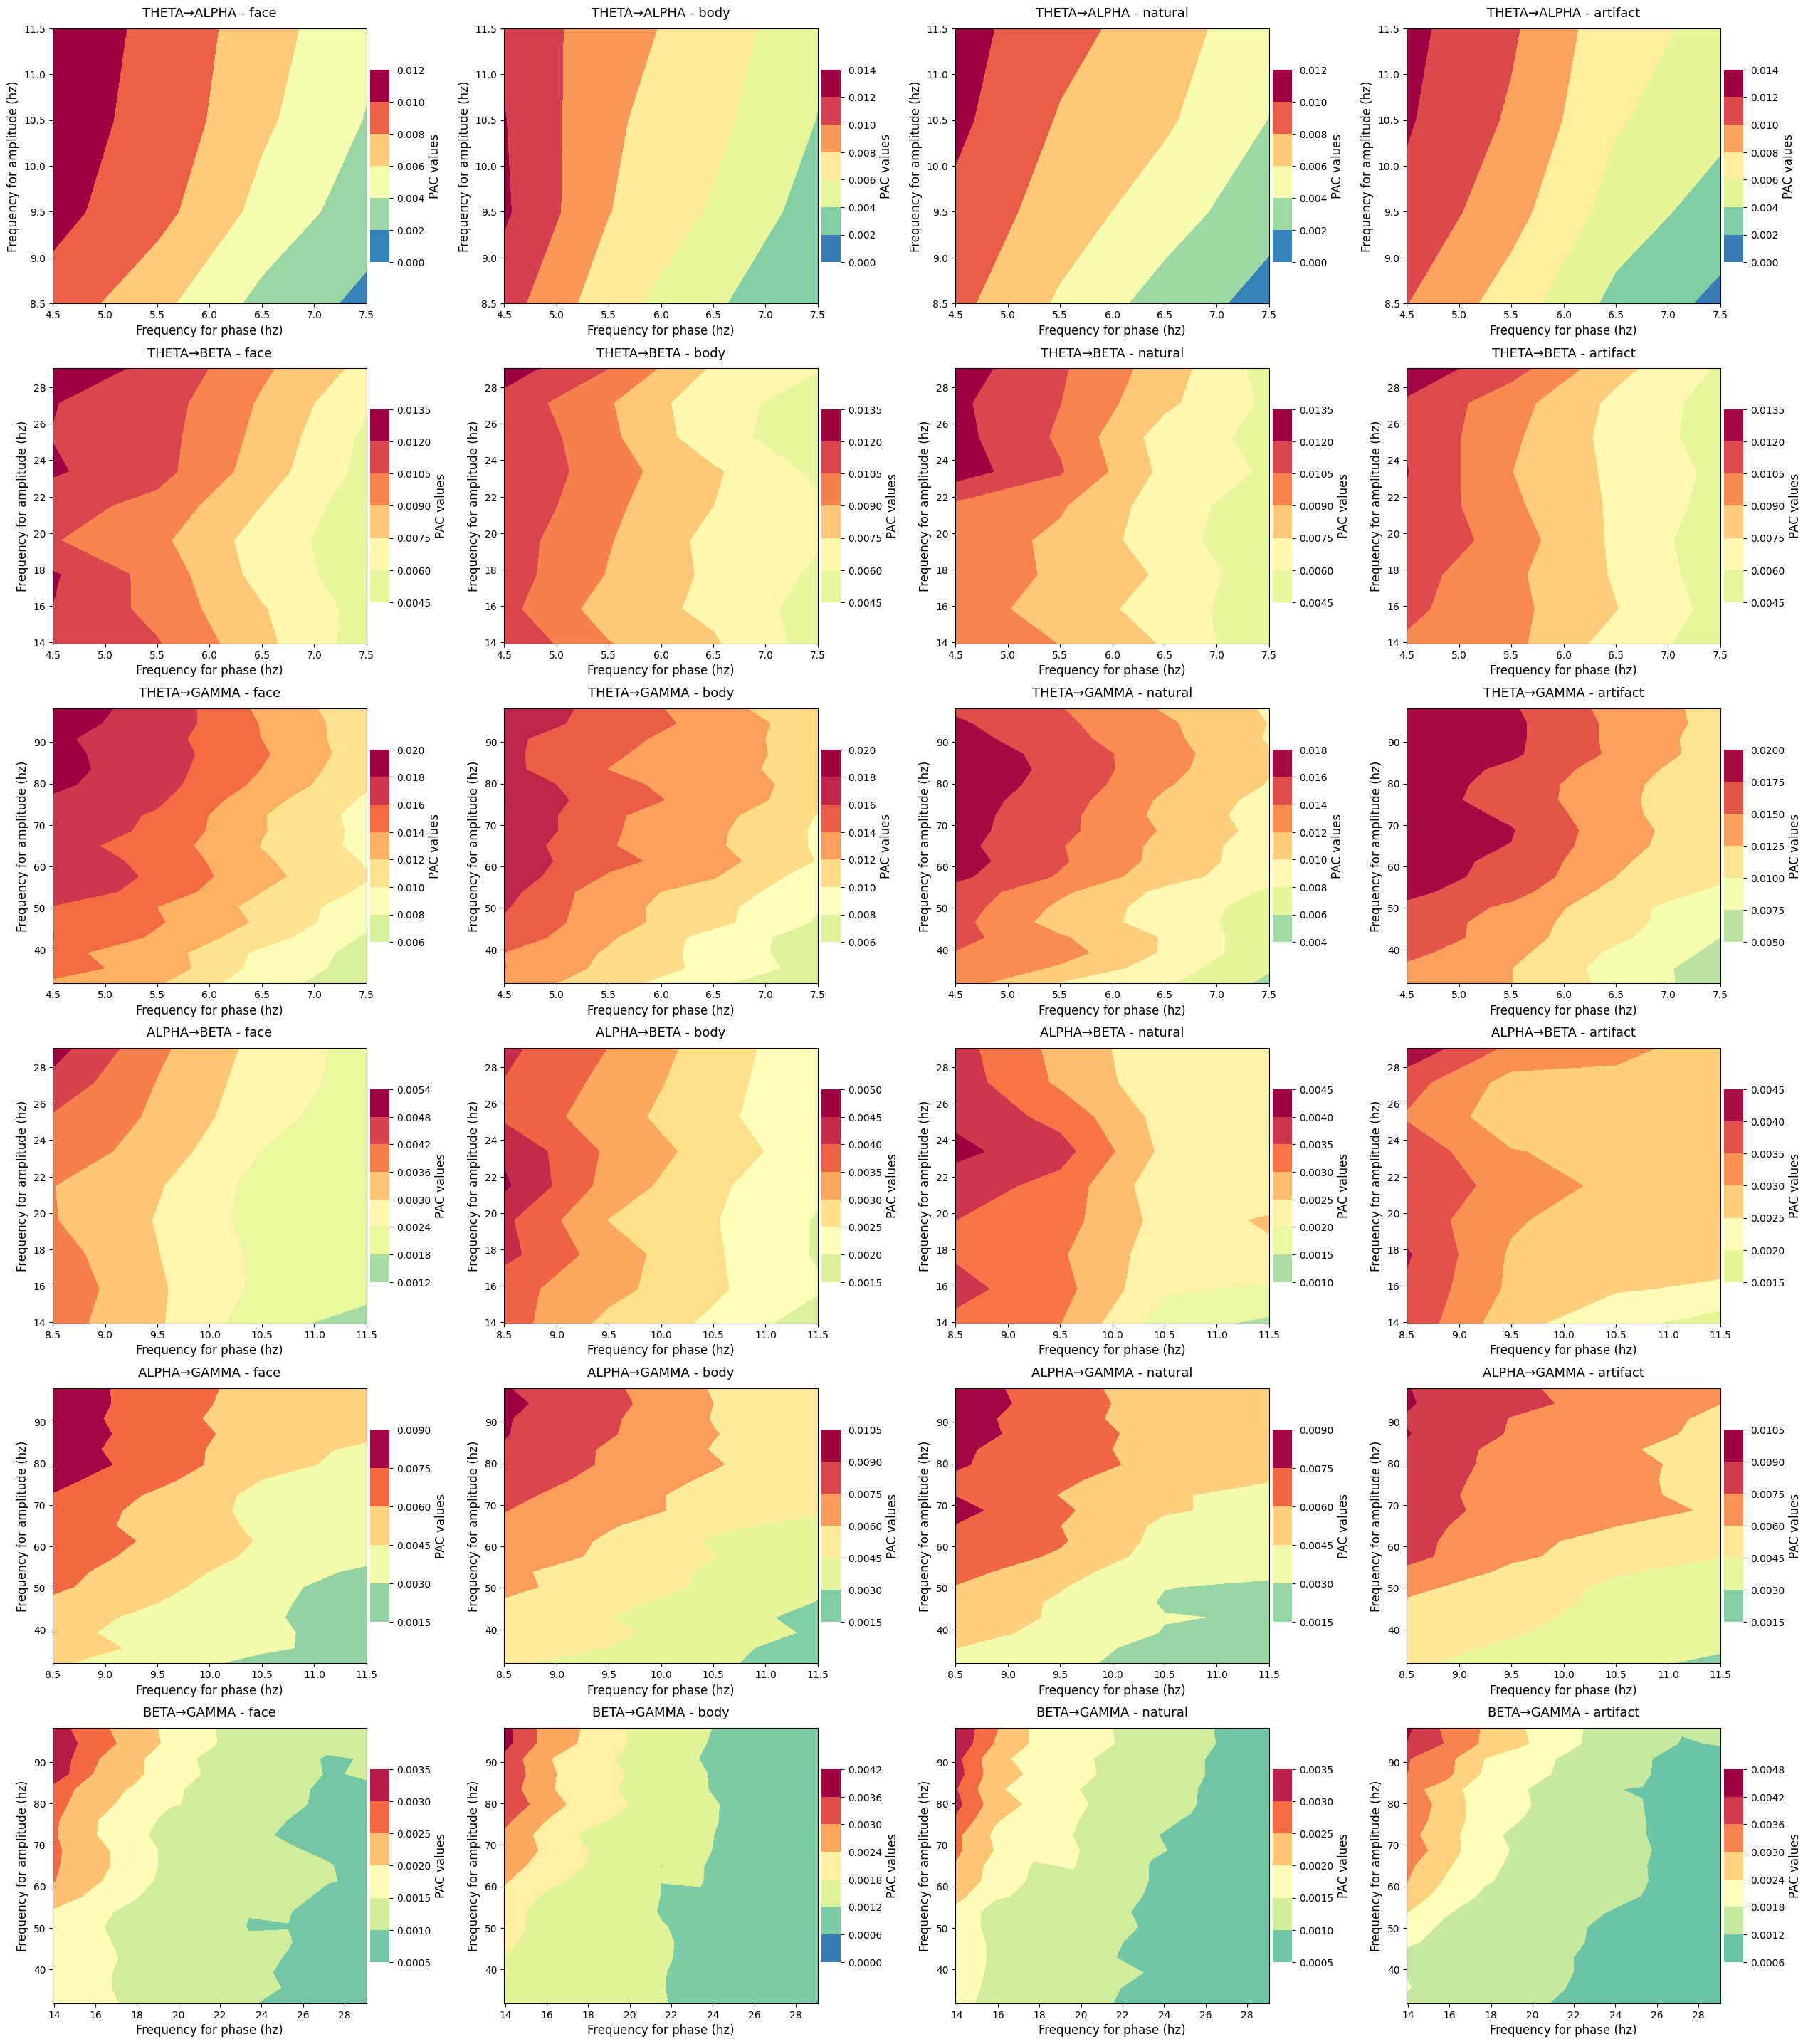

In [ ]:
import itertools
from tensorpac import Pac

plt.figure(figsize=(4 * fig_width, 6 * fig_height))

for i, ((pha_name, f_pha), (amp_name, f_amp)) in enumerate(itertools.combinations(bands.items(), 2)):
    p = Pac(idpac=(2, 0, 0), f_pha=f_pha, f_amp=f_amp, verbose=False)

    for j, (cat_name, data) in enumerate(category_data.items()):
        xpac = p.filterfit(sf, data, random_state=42)

        plt.subplot(6, 4, 4 * i + j + 1)
        p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', title=f"{pha_name.upper()}→{amp_name.upper()} - {cat_name}")

plt.tight_layout()
plt.savefig('pac_plots_mi.pdf', bbox_inches='tight')
plt.show()

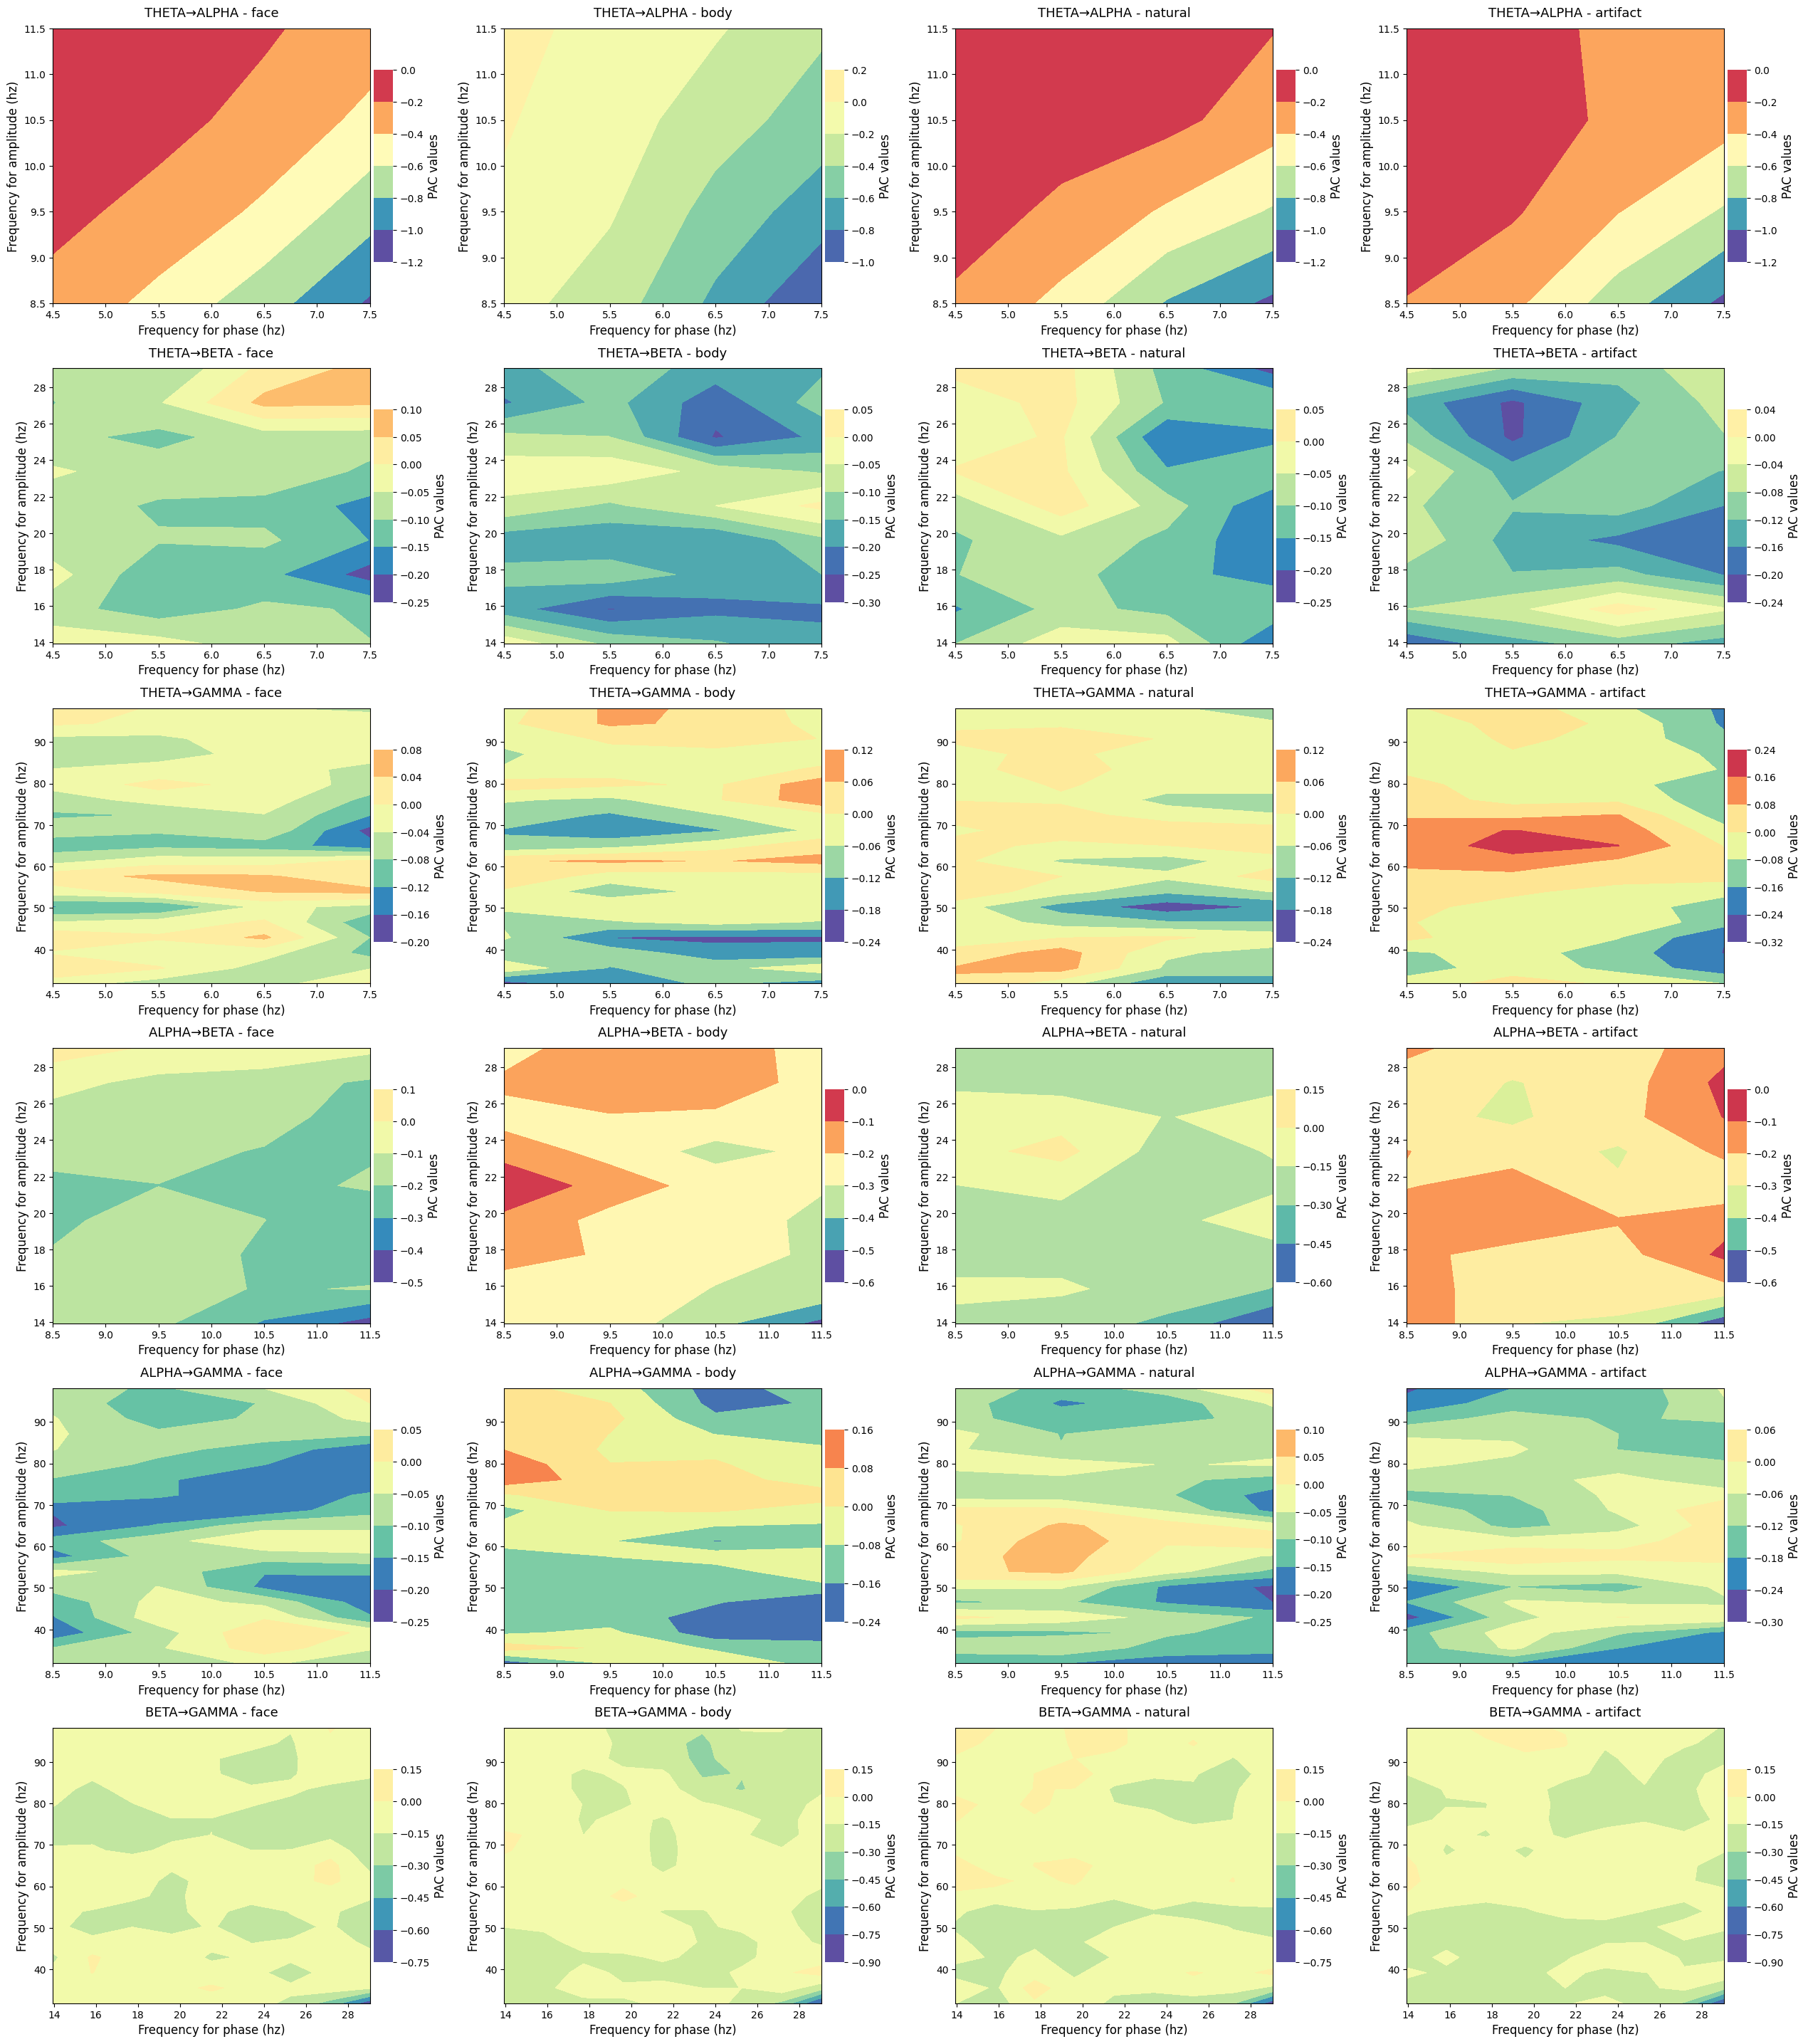

In [ ]:
plt.figure(figsize=(4 * fig_width, 6 * fig_height))

for i, ((pha_name, f_pha), (amp_name, f_amp)) in enumerate(itertools.combinations(bands.items(), 2)):
    p = Pac(idpac=(1, 2, 4), f_pha=f_pha, f_amp=f_amp, verbose=False)

    for j, (cat_name, data) in enumerate(category_data.items()):
        xpac = p.filterfit(sf, data, random_state=42)

        plt.subplot(6, 4, 4 * i + j + 1)
        p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', title=f"{pha_name.upper()}→{amp_name.upper()} - {cat_name}")

plt.tight_layout()
plt.savefig('pac_plots_canolty.pdf', bbox_inches='tight')
plt.show()

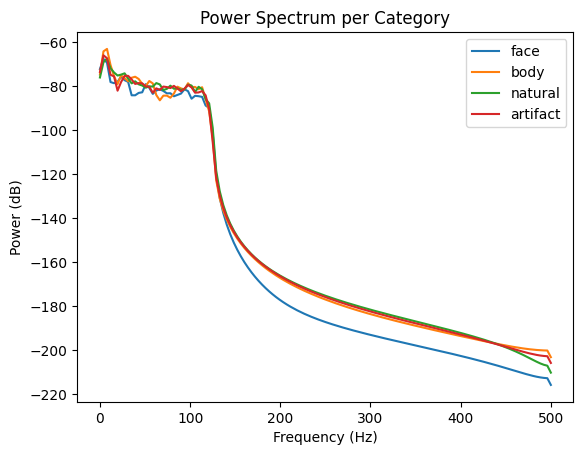

In [ ]:
from scipy.signal import welch

for category, data in category_data.items():
    f, Pxx = welch(data.mean(axis=0), fs=sf, nperseg=256)
    plt.plot(f, 10 * np.log10(Pxx), label=category)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.title("Power Spectrum per Category")
plt.legend()
plt.savefig('power_spectrum_per_category.pdf', bbox_inches='tight')
plt.show()